In [7]:
import cv2
import os
import numpy as np
from random import shuffle
import imutils #need to install this with pip
import matplotlib.pyplot as plt
from skimage import data, color, exposure
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline  

In [8]:
minDim = 80
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9

dims = (minDim, minDim)

hog = cv2.HOGDescriptor(dims, blockSize, blockStride, cellSize, nbins)

In [9]:
def getFeaturesWithLabel(imageData, hog, dims, label):
    data = []
    for img in imageData: 
        img = cv2.resize(img, dims)

        #for images with transparency layer, reduce to 3 layers
        feat = hog.compute(img[:,:,:3])
        
        data.append((feat, label))
    return data

In [10]:
#helper function for resizing images
def resize(img, scale):
    return cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)))

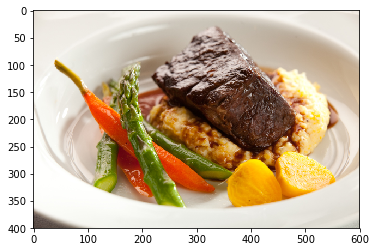

In [12]:
im = cv2.imread("entree-1.jpg")
if im.shape[0] > 400:
    scale = 400.0/im.shape[0]
else: scale = 1
im = resize(im, scale)

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

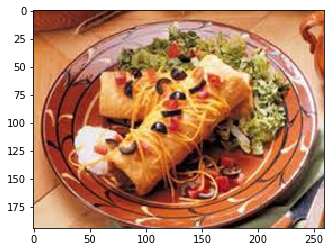

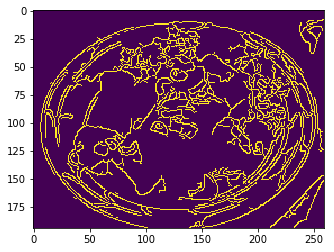

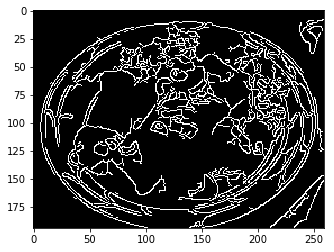

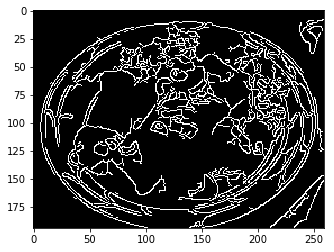

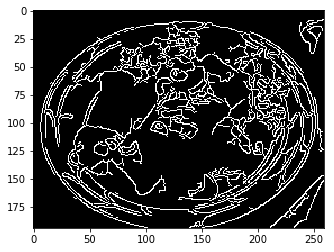

95
26


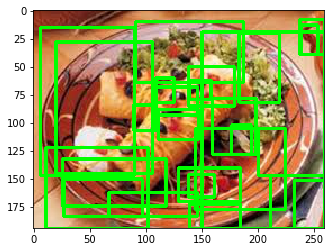

In [41]:
im = cv2.imread("Data/Training/Entree/42.jpg")
rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.show()

im = cv2.Canny(im,750,150)
plt.imshow(im)
plt.show()

imgray = im #cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
plt.imshow(imgray, cmap='gray')
plt.show()

flag, binaryImage = cv2.threshold(imgray, 85, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(binaryImage, cmap='gray')
plt.show()

im2, contours, hierarchy = cv2.findContours(binaryImage,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(im2, cmap='gray')
plt.show()

boxes = [cv2.boundingRect(c) for c in contours]
print(len(boxes))
boxes2 = [b for b in boxes if b[2]*b[3] > 300]
print(len(boxes2))

for x, y, w, h in boxes2:
    cv2.rectangle(rgb, (x,y),(x+w, y+h), (0, 255, 0), 2)
plt.imshow(rgb)
plt.show()

In [ ]:
def preprocess(image, lower, upper):
    #boundary in bgr color scheme for opencv

    lower = np.array(lower, dtype="uint8")
    upper = np.array(upper, dtype="uint8")

    # find the colors within the specified boundaries and apply
    # the mask
    mask = cv2.inRange(image, lower, upper)
    output = cv2.bitwise_and(image, image, mask = mask)
    #This takes image[x] and image[x] when mask is 1 (that is, it leaves it alone),
    #otherwise it makes image[x] = 0. The effect in this case is just image and mask. 
    #This is applied to all 3 channels
    
    return output, mask

In [ ]:
pimage, mask = preprocess(im,  [0,0, 0], [255, 255, 255])
plt.imshow(pimage)
plt.show()

In [ ]:
# detect people in the image
(rects, weights) = hog.detectMultiScale(im, winStride=(8, 8),
                                        padding=(16, 16), scale=1.05)

print(rects)
 
# draw the original bounding boxes
for (x, y, w, h) in rects:
    cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)
 
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

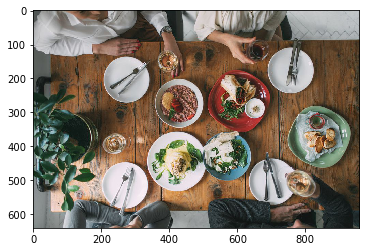

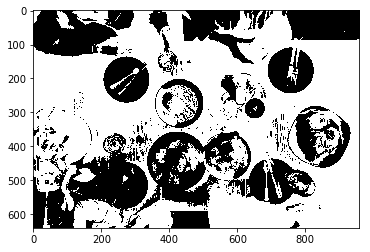

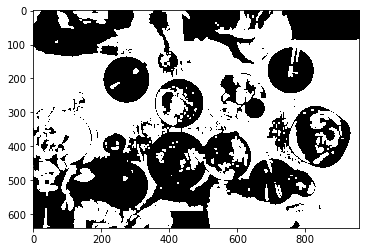

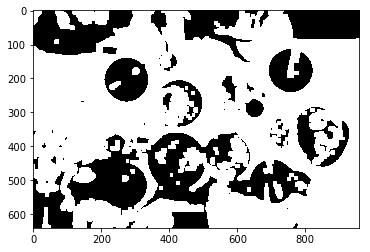

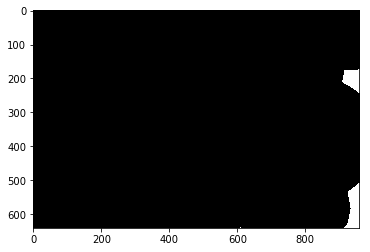

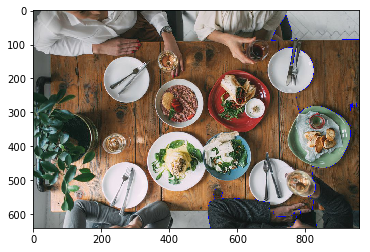

In [53]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

img = cv2.imread("Data/Test/table-2.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(thresh, cmap='gray')
plt.show()

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
plt.imshow(opening, cmap='gray')
plt.show()

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
plt.imshow(sure_bg, cmap='gray')
plt.show()

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
plt.imshow(sure_fg, cmap='gray')
plt.show()

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

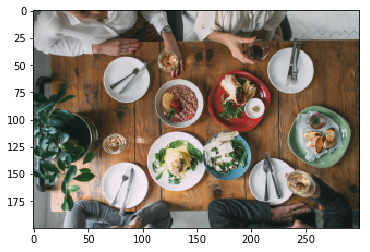

size (26, 14)
size (96, 26)
size (79, 79)
size (27, 40)
size (40, 40)
size (16, 22)
size (176, 176)


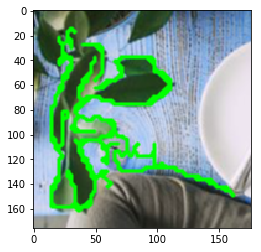

size (124, 122)
size (292, 232)


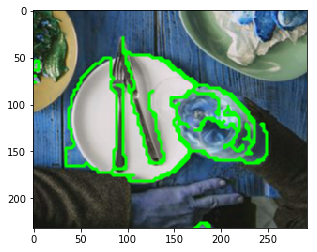

size (70, 57)
size (127, 112)
size (212, 220)


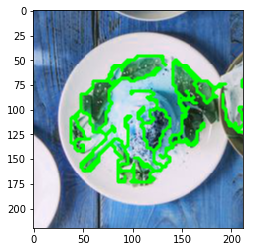

size (54, 136)
size (85, 73)
size (25, 44)
size (88, 84)
size (70, 28)
size (147, 81)
size (112, 193)
size (284, 283)


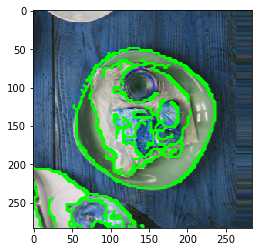

size (106, 150)
size (86, 128)
size (127, 150)
size (710, 655)


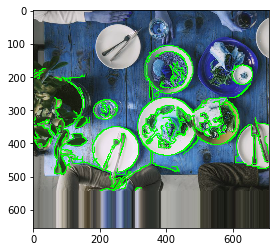

size (132, 157)
size (234, 384)


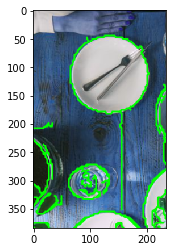

size (240, 240)


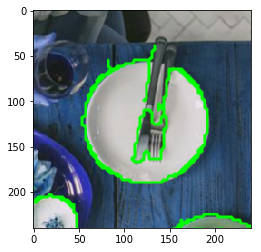

size (372, 382)


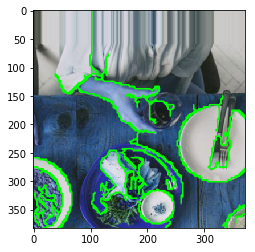

size (62, 57)
size (332, 333)


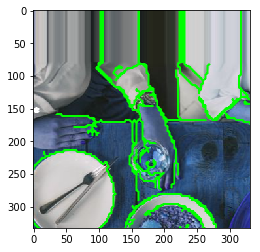

size (370, 165)


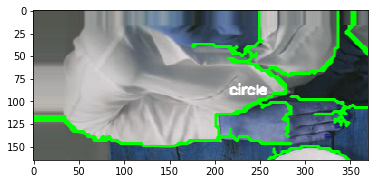

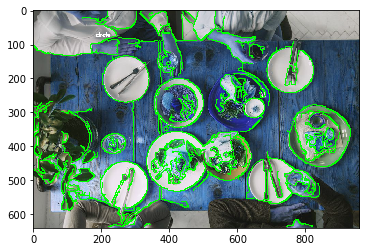

In [90]:
import cv2
import numpy as np
 
class ShapeDetector:
    def __init__(self):
        pass
 
    def detect(self, c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        
        # if the shape is a triangle, it will have 3 vertices
        if len(approx) == 3:
            shape = "triangle"
 
        # if the shape has 4 vertices, it is either a square or
        # a rectangle
        elif len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)
 
            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
 
        # if the shape is a pentagon, it will have 5 vertices
        elif len(approx) == 5:
            shape = "pentagon"
 
        # otherwise, we assume the shape is a circle
        else:
            shape = "circle"
 
        # return the name of the shape
        return shape
        
# load the image and resize it to a smaller factor so that
# the shapes can be approximated better
#image = cv2.imread("Data/Test/table-1.png")
image = cv2.imread("Data/Test/table-2.jpg")
resized = imutils.resize(image, width=300)
ratio = image.shape[0] / float(resized.shape[0])
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.show()    
 
# convert the resized image to grayscale, blur it slightly,
# and threshold it
#gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
gray = cv2.Canny(resized,750,150)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
#thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
#plt.imshow(gray, cmap='gray')
#plt.show()
#plt.imshow(blurred, cmap='gray')
#plt.show()
#plt.imshow(thresh, cmap='gray')
#plt.show()

#plt.imshow(cv2.Canny(resized,750,150), cmap='gray')
#plt.show()
 
# find contours in the thresholded image and initialize the
# shape detector
cnts = cv2.findContours(cv2.Canny(resized,750,150), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
#sd = ShapeDetector()

# loop over the contours
for c in cnts:
    # compute the center of the contour, then detect the name of the
    # shape using only the contour
    #M = cv2.moments(c)
    #cX = int((M["m10"] / M["m00"]) * ratio)
    #cY = int((M["m01"] / M["m00"]) * ratio)
    #shape = sd.detect(c)
 
    # multiply the contour (x, y)-coordinates by the resize ratio,
    # then draw the contours and the name of the shape on the image
    c = c.astype("float")
    c *= ratio
    c = c.astype("int")
    cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
    cv2.putText(image, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,
        0.5, (255, 255, 255), 2)
    
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    W = rect[1][0]
    H = rect[1][1]

    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)
    
    center = (int((x1+x2)/2), int((y1+y2)/2))
    size = (int(1.2*(x2-x1)),int(1.2*(y2-y1)))
    
    print("size",size)
    
    #m2D = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)

    cropped = cv2.getRectSubPix(image, size, center)    
    #cropped = cv2.warpAffine(cropped, m2D, size)
    
    #print(rect)
    
    if size[0] >= 150 and size[1] >= 150:
        plt.imshow(cropped)
        plt.show() 
 
# show the output image
plt.imshow(image)
plt.show()        